In [2]:
from keras.applications import VGG16 

2023-06-18 02:00:55.474028: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-18 02:00:55.486633: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-18 02:00:55.556010: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-18 02:00:55.556656: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-18 02:00:56.159382: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [4]:
conv_base = VGG16(weights='imagenet',
 include_top=False,
 input_shape=(150, 150, 3))

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [6]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator 
### 准备训练数据目录
base_dir = '/home/jovyan/work/newCatAndDog' 
# base_dir = '/Users/fchollet/Downloads/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train') 
validation_dir = os.path.join(base_dir, 'validation') 
test_dir = os.path.join(base_dir, 'test') 

datagen = ImageDataGenerator(rescale=1./255) 
batch_size = 20 
def extract_features(directory, sample_count):
     features = np.zeros(shape=(sample_count, 4, 4, 512)) 
     labels = np.zeros(shape=(sample_count))
     generator = datagen.flow_from_directory(
                                             directory, 
                                             target_size=(150, 150), 
                                             batch_size=batch_size, 
                                             class_mode='binary')
     i = 0
     for inputs_batch, labels_batch in generator:
         features_batch = conv_base.predict(inputs_batch)
         features[i * batch_size : (i + 1) * batch_size] = features_batch 
         labels[i * batch_size : (i + 1) * batch_size] = labels_batch
         i += 1
         if i * batch_size >= sample_count:break 
     return features, labels 
    
train_features, train_labels = extract_features(train_dir, 2000) 
validation_features, validation_labels = extract_features(validation_dir, 998) 
test_features, test_labels = extract_features(test_dir, 1000)

Found 5000 images belonging to 2 classes.
1/1 [==============================] - 1s 644ms/step
Found 998 images belonging to 2 classes.
1/1 [==============================] - 1s 578ms/step
Found 1998 images belonging to 2 classes.
1/1 [==============================] - 1s 705ms/step


In [8]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (998, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [9]:
from keras import models
from keras import layers
from keras import optimizers 
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid')) 
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
             loss='binary_crossentropy',
             metrics=['acc']) 
history = model.fit(train_features, train_labels,
             epochs=30,
             batch_size=20,
             validation_data=(validation_features, validation_labels))

Epoch 1/30


/opt/conda/lib/python3.11/site-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


100/100 [==============================] - 1s 5ms/step - loss: 0.5896 - acc: 0.6890 - val_loss: 0.4408 - val_acc: 0.8257
Epoch 2/30
100/100 [==============================] - 0s 5ms/step - loss: 0.4367 - acc: 0.8040 - val_loss: 0.3669 - val_acc: 0.8517
Epoch 3/30
100/100 [==============================] - 0s 5ms/step - loss: 0.3754 - acc: 0.8385 - val_loss: 0.3487 - val_acc: 0.8417
Epoch 4/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3298 - acc: 0.8555 - val_loss: 0.3102 - val_acc: 0.8647
Epoch 5/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3054 - acc: 0.8715 - val_loss: 0.2989 - val_acc: 0.8697
Epoch 6/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2807 - acc: 0.8815 - val_loss: 0.2942 - val_acc: 0.8737
Epoch 7/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2608 - acc: 0.8990 - val_loss: 0.2824 - val_acc: 0.8808
Epoch 8/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2519 - acc:

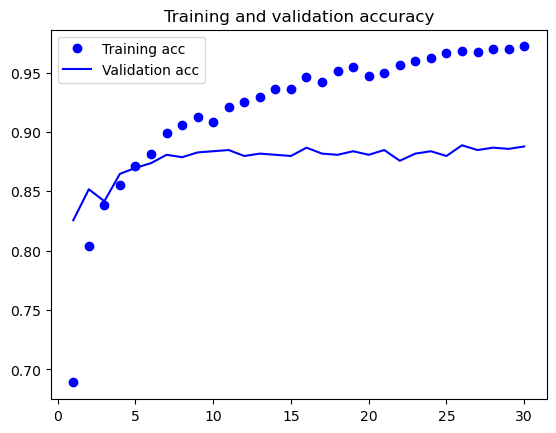

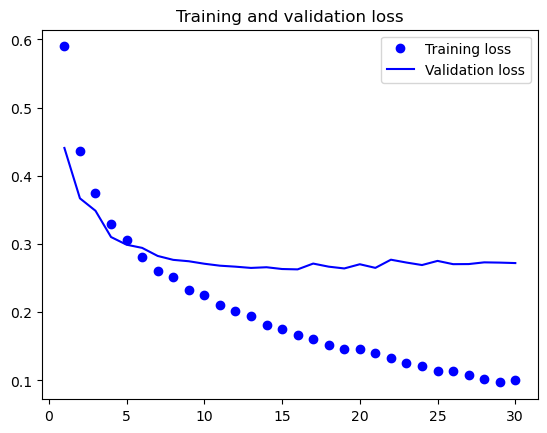

In [10]:
import matplotlib.pyplot as plt 
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss'] 
epochs = range(1, len(acc) + 1) 
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend() 
plt.figure() 
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend() 
plt.show()